<img src="gothic.png" />

In [1]:
# first let's import the libraries and functions we need
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import string
from collections import Counter, defaultdict, OrderedDict
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# for this example, I've selected one text from the "corpora" folder; the path will be added when we run the function
title_file = 'ShelleyMary_Frankenstein_Gutenberg.txt'
title = "Frankenstein"

### Beyond black, white and red
First we needed to define what color words we were looking for.

The corpus included works that were at least a century old, so it was unlikely that the authors of those works thought or talked about color the same way we do in the 2010s.  To get a reliable list of historical color words, we turned to the Oxford English Dictionary’s Historical Thesaurus.  It lists English color words, and for each provides the year of it’s first recorded use, and the color family it belongs to.

From our original data set, I read a csv file into a short function and eliminated everything after 1914, since it’s not clear from the Thesaurus when words fell out of usage.  Based on the color grouping in the OEDHT, I also assigned each color a hex value using this function.

In [3]:
def id_color_words():
    """
    Gets color words from the csv file and puts them into a dict where key = word
    and value = (hex value, color family); removes pre-1914 color words.
    """
    color_word_dict = {}
    modern_color_words = []
    color_data = csv.reader(open('./color_names.csv'), delimiter=",", quotechar='"')
    next(color_data, None)

    for row in color_data:
        name = row[0].lower()
        year = int(row[1])
        if ' ' not in name:
            if year < 1914:
                family = row[2].lower()
                hex_value = row[3].lower()
                color_word_dict[name] = (hex_value, family)
            else:
                modern_color_words.append((year, name))
                   
    return color_word_dict, modern_color_words

In [17]:
color_dict, modern_color_words = id_color_words()

print("There are %d color words in our dictionary that were in use before 1914, per the OED." % len(color_dict))
print()
sample_colors = list(color_dict.keys())[230:240]
print("Here is a sample - first value is the HTML color, the second is the color family.")
for s in sample_colors:
    print(s, ":", color_dict[s])

There are 980 color words in our dictionary that were in use before 1914, per the OED.

Here is a sample - first value is the HTML color, the second is the color family.
miniate : ('red', 'bright red or scarlet')
nasturtium-red : ('red', 'bright red or scarlet')
blood-red : ('crimson', 'deep red or crimson')
bloody : ('crimson', 'deep red or crimson')
purpurine : ('purple', 'purple ')
sanguine : ('crimson', 'deep red or crimson')
tuly : ('crimson', 'deep red or crimson')
murrey : ('crimson', 'deep red or crimson')
purpure : ('purple', 'purple ')
crimson : ('crimson', 'deep red or crimson')


In [5]:
print("Here are the post-1914 words and the year of first usage according to the Oxford English Dictionary.")
print("The 20th century ushered in food-related color words including avocado, citron, cocoa, mustard, pimento & toffee.")
print()
print(json.dumps(dict(sorted(modern_color_words, key=lambda x: x[0])), indent=1))

Here are the post-1914 words and the year of first usage according to the Oxford English Dictionary.
The 20th century ushered in food-related color words including avocado, citron, cocoa, mustard, pimento & toffee.

{
 "1918": "shadow-grey",
 "1919": "mustard",
 "1921": "pimento",
 "1922": "straw-pale",
 "1923": "sahara",
 "1924": "hennaed",
 "1927": "greige",
 "1928": "mimosa",
 "1931": "magnolia-pink",
 "1934": "safari",
 "1935": "salmony",
 "1937": "seaweed-green",
 "1938": "guinea-gold",
 "1941": "prune-dark",
 "1942": "cocoa",
 "1946": "whale-blue",
 "1947": "avocado",
 "1949": "saffronic",
 "1950": "wine",
 "1951": "bone-coloured",
 "1953": "pinko-grey",
 "1961": "toffee-brown",
 "1962": "peppery",
 "1963": "magnolia",
 "1965": "nutmeg",
 "1970": "flame",
 "1971": "sunshine-yellow",
 "1975": "sludgy",
 "1977": "tangerine-coloured",
 "1978": "spun-golden",
 "1981": "pepperminty",
 "1991": "mango"
}


### ‘rose’ != ‘rose’ != ‘rose’
<div align="center" style="margin: 0 auto;">
    <div style="width: 30%;float: left;"><img src="roseisarose.gif"></div>
    <div><p>First we needed to define what color words we were looking for.</p> 

<p> </p> 


<p></p> 
    </div>
</div>

In [6]:
def process_text(filename):
    """
    This function generates a list of tokens with punctuation stopwords, and spaces removed for the whole text.
    It also applies NLTK's part of speech tagging function to determine if words are nouns, adjectives, verbs, etc.
    """
    text_tokens = []

    file_path = "./corpora/" + filename
    stop = list(set(stopwords.words('english')))
    punc = [p for p in string.punctuation]
    stop_punc = stop + punc + ["''", '``']

    text = open(file_path, 'r')

    for row in text:
        tokens = pos_tag(word_tokenize(row.lower()))
        if len(tokens) is not 0:
            # puts everything in lowercase, removes punctuation and stopwords
            tokens = [token for token in tokens if token[0] not in stop_punc]
            # adds row tokens to master list
            text_tokens.extend(tokens)

    return text_tokens

In [7]:
processed = process_text(title_file)

In [8]:
print(processed[300:320])

[('dying', 'JJ'), ('injunction', 'NN'), ('forbidden', 'VBN'), ('uncle', 'NN'), ('allow', 'VB'), ('embark', 'VB'), ('seafaring', 'JJ'), ('life', 'NN'), ('visions', 'NNS'), ('faded', 'VBD'), ('perused', 'VBD'), ('first', 'JJ'), ('time', 'NN'), ('poets', 'NNS'), ('whose', 'WP$'), ('effusions', 'NNS'), ('entranced', 'VBD'), ('soul', 'NN'), ('lifted', 'VBD'), ('heaven', 'VB')]


In [42]:
def find_color_words(t, color_dict):
    colors = color_dict.keys()
    color_words = []
    concurrent_color_words = []
    tags = ['JJ', 'NN']
    
    for i in range(len(t)-1):
        if t[i][1] in tags and t[i][0] in colors:
            color_words.append(t[i])
            if t[i+1][1] in tags and t[i+1][0] in colors:
                color_words.append(t[i+1])
                concurrent_color_words.append((t[i], t[i + 1]))
                i += 1
            else:
                continue
        
    return color_words, concurrent_color_words

In [61]:
color_in_text, concurrent_color_words = find_color_words(processed, color_dict)

print("Here's a sample of what our list of color words looks like:")
print(color_in_text[:20])
print()
if len(concurrent_color_words) > 1:
    print("Here are the concurrent color words, instances where we had a color noun with a color adjective:")
    print(concurrent_color_words)
else:
    print("No concurrent color words (e.g. 'red rose' or 'yellow orange') were found!")

Here's a sample of what our list of color words looks like:
[('snow', 'JJ'), ('snow', 'NN'), ('snow', 'NN'), ('snow', 'NN'), ('straw', 'NN'), ('gold', 'NN'), ('blue', 'JJ'), ('stone', 'NN'), ('scarlet', 'NN'), ('white', 'JJ'), ('grey', 'NN'), ('black', 'JJ'), ('yellow', 'JJ'), ('yellow', 'JJ'), ('black', 'JJ'), ('pearly', 'JJ'), ('black', 'JJ'), ('livid', 'JJ'), ('yellow', 'JJ'), ('white', 'JJ')]

No concurrent color words (e.g. 'red rose' or 'yellow orange') were found!


In [62]:
nouns = Counter([n[0] for n in color_in_text if n[1] == 'NN'])
total_nouns = sum(nouns.values())
adjectives = Counter([a[0] for a in color_in_text if a[1] == 'JJ'])
total_adjectives = sum(adjectives.values())
total_color_words = len(color_in_text)

In [63]:
print("There are %d nouns in our color word list:" % total_nouns)
print(nouns)
print()
print("And %d adjectives in our color word list:" % total_adjectives)
print(adjectives)

There are 71 nouns in our color word list:
Counter({'water': 16, 'snow': 13, 'straw': 7, 'snowy': 5, 'milk': 4, 'blue': 3, 'stone': 2, 'grey': 2, 'livid': 2, 'mourning': 2, 'mole': 2, 'gold': 1, 'scarlet': 1, 'pitchy': 1, 'stony': 1, 'smoke': 1, 'bloody': 1, 'pink': 1, 'bone': 1, 'iron': 1, 'oatmeal': 1, 'sandy': 1, 'silver': 1, 'steel': 1})

And 61 adjectives in our color word list:
Counter({'black': 18, 'white': 10, 'blue': 8, 'green': 5, 'yellow': 4, 'verdant': 2, 'snowy': 2, 'silver': 2, 'snow': 1, 'pearly': 1, 'livid': 1, 'rosy': 1, 'raven': 1, 'red': 1, 'golden': 1, 'stony': 1, 'sunny': 1, 'wan': 1})


In [64]:
pct_color_words = round((total_color_words/len(processed))*100, 2)
print("%s is %s percent color words."% (title, pct_color_words))
print("%d percent of the color words are nouns." % round((total_nouns/total_color_words)*100, 1))
print("%d percent of the color words are adjectives." % round((total_adjectives/total_color_words)*100, 1))

Frankenstein is 0.38 percent color words.
53 percent of the color words are nouns.
46 percent of the color words are adjectives.


In [65]:
def group_to_plot(color_dict, c_i_t):
    color_summary = defaultdict(int)
    for c in c_i_t:
        color_summary[color_dict[c[0]][0]] += 1
    color_sum_a = dict(OrderedDict(sorted(color_summary.items(), key=lambda t: t[1])))
    color_sum_d = dict(OrderedDict(sorted(color_summary.items(), key=lambda t: t[1], reverse=True)))
    return color_sum_a, color_sum_d

In [66]:
html_color_counts_asc, html_color_counts_dsc  = group_to_plot(color_dict, color_in_text)
print (json.dumps(html_color_counts_dsc, indent=1))

{
 "snow": 21,
 "black": 20,
 "cadetblue": 16,
 "blue": 13,
 "silver": 13,
 "lightyellow": 7,
 "dimgrey": 7,
 "green": 7,
 "yellow": 6,
 "white": 4,
 "dodgerblue": 3,
 "gold": 2,
 "red": 2,
 "grey": 2,
 "pink": 2,
 "lightslategrey": 2,
 "seashell": 1,
 "whitesmoke": 1,
 "crimson": 1,
 "ivory": 1,
 "slategrey": 1
}


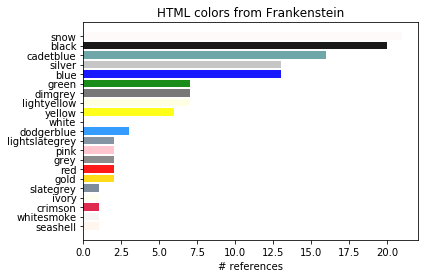

In [68]:
colors = list(html_color_counts_asc.keys())
counts = list(html_color_counts_asc.values())
y_pos = np.arange(len(counts))

plt.barh(y_pos, counts, align='center', alpha=0.9, color=colors)
plt.yticks(y_pos, colors)
plt.xlabel('# references')
plt.title('HTML colors from ' + title)
 
plt.show()